In [1]:
import glob
from pathlib import Path

import torch
import pandas as pd
import torch.nn as nn
import seaborn as sns
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader

################## import all of our classes and functions ############
from src.loss import vggL
from src.config import cfg, root_path
from src.data_loaders import SuperResolutionDataLoader
from src.models.srgan import Generator, Discriminator
from src.utils import show_image, plot_examples
from sklearn.model_selection import train_test_split
from src.train_validator import train_fn, validate_fn

#######################################################################

/home/rjn/miniconda3/envs/nlp_term2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################# Print GPU Info #####################
if torch.cuda.is_available():
    print("CUDA is available. GPU details:")

    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(
            f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB"
        )
        print(
            f"  Multiprocessors: {torch.cuda.get_device_properties(i).multi_processor_count}"
        )
        print(
            f"  Compute Capability: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}"
        )
else:
    print("CUDA is not available. No GPU detected.")
#############################################################

CUDA is available. GPU details:
Number of GPUs: 1

GPU 0:
  Name: Quadro P1000
  Total Memory: 4.23 GB
  Multiprocessors: 4
  Compute Capability: 6.1


In [3]:
# make the output dir
Path(root_path).joinpath("output/images").mkdir(exist_ok=True, parents=True)

In [4]:

# get the images dataset path
images_pth = cfg.dataset.images_dir

train_paths, test_paths = train_test_split(
    sorted(glob.glob(images_pth + "/*.*")),
    test_size=0.2,
    random_state=42,
)


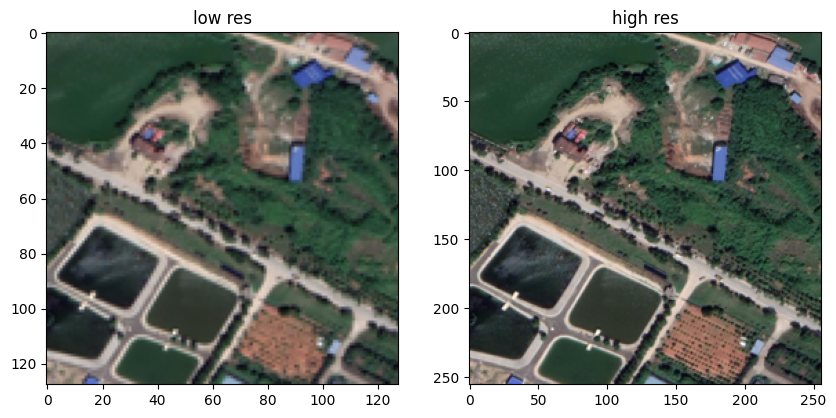

In [5]:
show_image(test_paths) # we do not want to normalize, so normalization is set to false. 

In [6]:
train = SuperResolutionDataLoader(train_paths) # without the Normalization
train_loader = DataLoader(train, batch_size=cfg.train.batch_size, num_workers=cfg.train.n_cpu)

val = SuperResolutionDataLoader(test_paths) # without the Normalization
val_loader = DataLoader(val, batch_size=cfg.train.batch_size, num_workers=cfg.train.n_cpu)

In [7]:

gen = Generator(in_channels=3).to(cfg.device.device)
disc = Discriminator(in_channels=3).to(cfg.device.device)
opt_gen = optim.Adam(gen.parameters(), lr=cfg.train.learning_rate, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=cfg.train.learning_rate, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/home/rjn/miniconda3/envs/nlp_term2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rjn/miniconda3/envs/nlp_term2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_psnr = 0
model_save_path = f"{str(root_path)}/output/best_model.pth"

d_losses = []
g_losses = []
val_d_losses = []
val_g_losses = []
val_ssim = []
val_psnr = []

for epoch in range(cfg.train.n_epochs):
    print(f"Epoch {epoch + 1}/{cfg.train.n_epochs}")
    gen_loss, disc_loss = train_fn(
        train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss
    )
    plot_examples(gen, train_loader, epoch)
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)

    val_gen_loss, val_disc_loss, psnr_var, ssim_var = validate_fn(
        val_loader, disc, gen, mse, bce, vgg_loss
    )
    plot_examples(gen, val_loader, epoch)

    val_ssim.append(ssim_var)
    val_psnr.append(psnr_var)
    val_d_losses.append(val_disc_loss)
    val_g_losses.append(val_gen_loss)

    # Save the model if the PSNR improves
    if psnr_var > best_psnr:
        best_psnr = psnr_var
        torch.save(gen.state_dict(), model_save_path)
        print(f"New best PSNR: {psnr_var:.4f}. Model saved.")

    print(
        f"Train Generator Loss: {gen_loss:.4f}, Train Discriminator Loss: {disc_loss:.4f}"
    )
    print(
        f"Validation Generator Loss: {val_gen_loss:.4f}, Validation Discriminator Loss: {val_disc_loss:.4f}"
    )
    print(f"Validation PSNR: {psnr_var:.4f}, Validation SSIM: {ssim_var:.4f}")


In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Train Generator and Discriminator losses
axs[0, 0].plot(g_losses, label="Train Generator Loss", color="tab:blue")
axs[0, 0].plot(d_losses, label="Train Discriminator Loss", color="tab:orange")
axs[0, 0].set_title("Train Generator and Discriminator Losses")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Validation Generator and Discriminator losses
axs[0, 1].plot(
    val_g_losses, label="Validation Generator Loss", color="tab:blue", linestyle="--"
)
axs[0, 1].plot(
    val_d_losses,
    label="Validation Discriminator Loss",
    color="tab:orange",
    linestyle="--",
)
axs[0, 1].set_title("Validation Generator and Discriminator Losses")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot PSNR
axs[1, 0].plot(val_psnr, label="Validation PSNR", color="tab:green")
axs[1, 0].set_title("Validation PSNR")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("PSNR")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot SSIM
axs[1, 1].plot(val_ssim, label="Validation SSIM", color="tab:red")
axs[1, 1].set_title("Validation SSIM")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("SSIM")
axs[1, 1].legend()
axs[1, 1].grid(True)

# Customize the overall plot layout
plt.suptitle("Training and Validation Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot
plt.savefig(f"{str(root_path)}/output/training_validation_metrics.png")


In [ ]:
data = {
    "d_losses": d_losses,
    "g_losses": g_losses,
    "val_d_losses": val_d_losses,
    "val_g_losses": val_g_losses,
    "val_ssim": val_ssim,
    "val_psnr": val_psnr,
}

df = pd.DataFrame(data)

df.to_csv(f"{str(root_path)}/output/train_metrics.csv", index=False)
